# データの用意

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_data(file_path):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in open(file_path, encoding='utf-8'):
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

# 読み込み＆Tokenizerによる数値化
x_train, tokenizer_en = load_data('data/train.en')
y_train, tokenizer_ja = load_data('data/train.ja')

en_vocab_size = len(tokenizer_en.word_index) + 1
ja_vocab_size = len(tokenizer_ja.word_index) + 1

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.02, random_state=42)

# パディング
x_train = pad_sequences(x_train, padding='post')
y_train = pad_sequences(y_train, padding='post')

seqX_len = len(x_train[0])
seqY_len = len(y_train[0])

# モデル構築

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM

emb_dim = 256
hid_dim = 256

## 符号化器
# Inputレイヤー（返り値としてテンソルを受け取る）
encoder_inputs = Input(shape=(seqX_len,))

# モデルの層構成（手前の層の返り値テンソルを、次の接続したい層に別途引数として与える）
# InputレイヤーとEmbeddingレイヤーを接続（+Embeddingレイヤーのインスタンス化）
encoder_embedded = Embedding(en_vocab_size, emb_dim, mask_zero=True)(encoder_inputs) # shape: (seqX_len,)->(seqX_len, emb_dim)
# EmbeddingレイヤーとLSTMレイヤーを接続（+LSTMレイヤーのインスタンス化）
_, *encoder_states = LSTM(hid_dim, return_state=True)(encoder_embedded)  # shape: (seqX_len, emb_dim)->(hid_dim, )
# このLSTMレイヤーの出力に関しては下記に補足あり

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
## 復号化器
# Inputレイヤー（返り値としてテンソルを受け取る）
decoder_inputs = Input(shape=(seqY_len,))

# モデルの層構成（手前の層の返り値テンソルを、次の接続したい層に別途引数として与える）
# InputレイヤーとEmbeddingレイヤーを接続
decoder_embedding = Embedding(ja_vocab_size, emb_dim) # 後で参照したいので、レイヤー自体を変数化
decoder_embedded = decoder_embedding(decoder_inputs)  # shape: (seqY_len,)->(seqY_len, emb_dim)
# EmbeddingレイヤーとLSTMレイヤーを接続（encoder_statesを初期状態として指定）
decoder_lstm = LSTM(hid_dim, return_sequences=True, return_state=True) # 後で参照したいので、レイヤー自体を変数化
decoder_outputs, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states) # shape: (seqY_len, emb_dim)->(seqY_len, hid_dim)
# LSTMレイヤーとDenseレイヤーを接続
decoder_dense = Dense(ja_vocab_size, activation='softmax') # 後で参照したいので、レイヤー自体を変数化
decoder_outputs = decoder_dense(decoder_outputs) # shape: (seqY_len, hid_dim)->(seqY_len, ja_vocab_size)

# モデル構築（入力は符号化器＆復号化器、出力は復号化器のみ）
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# 今回は、sparse_categorical_crossentropy（正解ラベルとしてone_hot表現のベクトルでなく数値を受け取るcategorical_crossentropy）を使用

In [7]:
import numpy as np

train_target = np.hstack((y_train[:, 1:], np.zeros((len(y_train),1), dtype=np.int32)))

model.fit([x_train, y_train], np.expand_dims(train_target, -1), batch_size=128, epochs=15, verbose=2, validation_split=0.2)

Train on 39200 samples, validate on 9800 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/15
 - 777s - loss: 2.9716 - val_loss: 2.3077
Epoch 2/15
 - 760s - loss: 2.0851 - val_loss: 1.9479
Epoch 3/15
 - 652s - loss: 1.8240 - val_loss: 1.7778
Epoch 4/15
 - 709s - loss: 1.6640 - val_loss: 1.6552
Epoch 5/15
 - 681s - loss: 1.5366 - val_loss: 1.5692
Epoch 6/15
 - 549s - loss: 1.4270 - val_loss: 1.4911
Epoch 7/15
 - 563s - loss: 1.3290 - val_loss: 1.4270
Epoch 8/15
 - 629s - loss: 1.2437 - val_loss: 1.3796
Epoch 9/15
 - 566s - loss: 1.1693 - val_loss: 1.3369
Epoch 10/15
 - 595s - loss: 1.1036 - val_loss: 1.3089
Epoch 11/15
 - 603s - loss: 1.0457 - val_loss: 1.2890
Epoch 12/15
 - 676s - loss: 0.9926 - val_loss: 1.2661
Epoch 13/15
 - 687s - loss: 0.9432 - val_loss: 1.2619
Epoch 14/15
 - 670s - loss: 0.8986 - val_loss: 1.2539
Epoch 15/15
 - 636s - loss: 0.8571 - val_loss: 1.2422


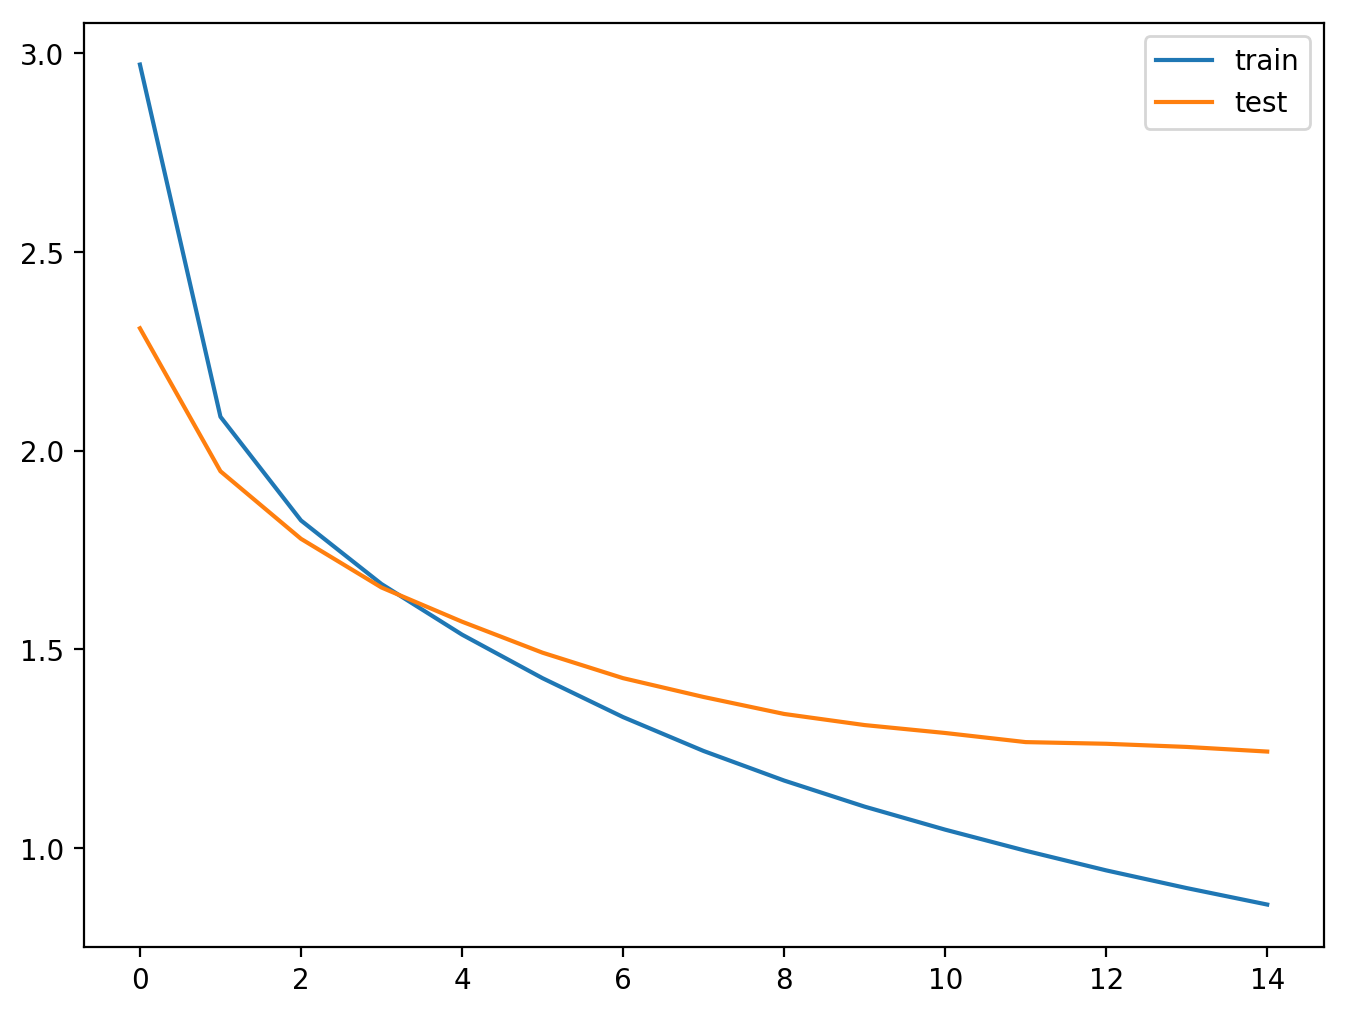

In [10]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'test'])
plt.show()

# モデルによる生成

In [12]:
# サンプリング用（生成用）のモデルを作成

# 符号化器（学習時と同じ構成、学習したレイヤーを利用）
encoder_model = Model(encoder_inputs, encoder_states)

# 復号化器
decoder_states_inputs = [Input(shape=(hid_dim,)), Input(shape=(hid_dim,))] # decorder_lstmの初期状態指定用(h_t, c_t)

decoder_inputs = Input(shape=(1,))
decoder_embedded = decoder_embedding(decoder_inputs) # 学習済みEmbeddingレイヤーを利用
decoder_outputs, *decoder_states = decoder_lstm(decoder_embedded, initial_state=decoder_states_inputs) # 学習済みLSTMレイヤーを利用
decoder_outputs = decoder_dense(decoder_outputs) # 学習済みDenseレイヤーを利用

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [13]:
def decode_sequence(input_seq, bos_eos, max_output_length = 1000):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.array(bos_eos[0])  # bos_eos[0]="<s>"に対応するインデックス
    output_seq= bos_eos[0][:]
    
    while True:
        output_tokens, *states_value = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
        output_seq += sampled_token_index
        
        if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
            break

        target_seq = np.array(sampled_token_index)

    return output_seq

In [26]:
detokenizer_en = dict(map(reversed, tokenizer_en.word_index.items()))
detokenizer_ja = dict(map(reversed, tokenizer_ja.word_index.items()))

text_no = 0
input_seq = pad_sequences([x_test[text_no]], seqX_len, padding='post')
bos_eos = tokenizer_ja.texts_to_sequences(["<s>", "</s>"])

print('元の文:', ' '.join([detokenizer_en[i] for i in x_test[text_no]]))
print('生成文:', ' '.join([detokenizer_ja[i] for i in decode_sequence(input_seq, bos_eos)]))
print('正解文:', ' '.join([detokenizer_ja[i] for i in y_test[text_no]]))

元の文: <s> you may extend your stay in tokyo . </s>
生成文: <s> あなた は 東京 で 行 く 方 が 必要 で す 。 </s>
正解文: <s> 東京 滞在 を 延ば し て も い い で す よ 。 </s>


# モデルの可視化

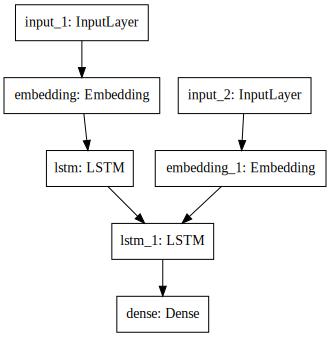

In [28]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

# 機械翻訳の評価

In [30]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

prediction = ['I', 'am', 'a', 'graduate', 'student', 'at', 'a', 'university']
reference = [['I', 'am', 'a', 'graduate', 'student', 'at', 'the', 'university', 'of', 'tokyo']]

print(sentence_bleu(reference, prediction))

0.5506953149031837


In [31]:
text_no = 1
input_seq = pad_sequences([x_test[text_no]], seqX_len, padding='post')
bos_eos = tokenizer_ja.texts_to_sequences(["<s>", "</s>"])

prediction = [detokenizer_ja[i] for i in decode_sequence(input_seq, bos_eos)]
reference = [[detokenizer_ja[i] for i in y_test[text_no]]]

print(prediction)
print(reference)

print(sentence_bleu(reference, prediction))

['<s>', '私', 'は', '学校', 'で', '勉強', 'し', 'ま', 'す', '。', '</s>']
[['<s>', '私', 'は', '学校', 'で', '勉強', 'する', '。', '</s>']]
0.5193071778680676
